<a href="https://colab.research.google.com/github/varunk04/computer_vision/blob/main/06_Feature_extraction(Fine_Tunning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning With Tensorflow Part 2: Fine-Tunning


1. "As is" transfer learning is when you take a pretrained model as it is and apply it to your task without any changes.
For example, many computer vision models are pretrained on the ImageNet dataset which contains 1000 different classes of images. This means passing a single image to this model will produce 1000 different prediction probability values (1 for each class).

 * This is helpful if you have 1000 classes of image you'd like to classify and they're all the same as the ImageNet classes, however, it's not helpful if you want to classify only a small subset of classes (such as 10 different kinds of food). Model's with "/classification" in their name on TensorFlow Hub provide this kind of functionality.

2. Feature extraction transfer learning is when you take the underlying patterns (also called weights) a pretrained model has learned and adjust its outputs to be more suited to your problem.
For example, say the pretrained model you were using had 236 different layers (EfficientNetB0 has 236 layers), but the top layer outputs 1000 classes because it was pretrained on ImageNet. To adjust this to your own problem, you might remove the original activation layer and replace it with your own but with the right number of output classes. The important part here is that only the top few layers become trainable, the rest remain frozen.

 * This way all the underlying patterns remain in the rest of the layers and you can utilise them for your own problem. This kind of transfer learning is very helpful when your data is similar to the data a model has been pretrained on.

3. Fine-tuning transfer learning is when you take the underlying patterns (also called weights) of a pretrained model and adjust (fine-tune) them to your own problem.

 * This usually means training some, many or all of the layers in the pretrained model. This is useful when you've got a large dataset (e.g. 100+ images per class) where your data is slightly different to the data the original model was trained on.
 
A common workflow is to "freeze" all of the learned patterns in the bottom layers of a pretrained model so they're untrainable. And then train the top 2-3 layers of so the pretrained model can adjust its outputs to your custom data (feature extraction).

After you've trained the top 2-3 layers, you can then gradually "unfreeze" more and more layers and run the training process on your own data to further fine-tune the pretrained model.

## Creating helper functions:

Helper functions are some usefull custom functions that are used repeatedly.

For example:
* pred_and_plot
* Unzip the file
* Plot_loss_curves
* Plot_confusion_matrix, etc

https://raw.githubusercontent.com/varunk04/Helper_functions/main/helper_functions.py

This file is uploaded in github which contains all the helper functions which can further be updated.

In [1]:
!wget https://raw.githubusercontent.com/varunk04/Helper_functions/main/helper_functions.py

--2023-05-25 11:21:48--  https://raw.githubusercontent.com/varunk04/Helper_functions/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-05-25 11:21:48 (103 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
from helper_functions import create_tensorboard_callback,plot_loss_curves,unzip_data, walk_through_dir

## Lets get the data:

In [9]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data('10_food_classes_10_percent.zip')

--2023-05-25 11:36:12--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.128, 173.194.203.128, 74.125.199.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   187MB/s    in 0.9s    

2023-05-25 11:36:13 (187 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [10]:
# Checking out the data files in unziped file:

walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [ ]:
# Creating training and test directory path:

train_dir  = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

In [ ]:
import tensorflow as tf

IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_data_10 = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                    image_size= IMG_SIZE,
                                                                    label_mode = 'categorical',
                                                                    batch_size = BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                image_size = IMG_SIZE,
                                                                batch_size = BATCH_SIZE,
                                                                label_mode = 'categorical')

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
train_data_10.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# See an example of batch of data:

for images, labels in train_data_10.take(1):
  print(images, labels)

tf.Tensor(
[[[[7.16428604e+01 2.56428566e+01 3.66428566e+01]
   [7.39285736e+01 2.79285717e+01 3.79285736e+01]
   [7.37857132e+01 2.87857132e+01 3.53571434e+01]
   ...
   [1.79316635e+02 1.68173721e+02 1.63755386e+02]
   [2.06357101e+02 1.90785675e+02 1.85632614e+02]
   [1.57906769e+02 1.38610840e+02 1.34233292e+02]]

  [[7.20714340e+01 2.60714283e+01 3.70714264e+01]
   [7.43571472e+01 2.83571434e+01 3.83571434e+01]
   [7.42142868e+01 2.92142849e+01 3.59693871e+01]
   ...
   [1.31806458e+02 1.13898239e+02 1.06969742e+02]
   [1.56122467e+02 1.33693893e+02 1.26306122e+02]
   [1.28366425e+02 1.04325546e+02 9.58153610e+01]]

  [[7.28979568e+01 2.68979588e+01 3.78979607e+01]
   [7.49285736e+01 2.89285717e+01 3.89285736e+01]
   [7.56530609e+01 3.06530609e+01 3.76530609e+01]
   ...
   [8.47959290e+01 5.78469162e+01 4.53775444e+01]
   [9.17756577e+01 6.04899445e+01 4.71634064e+01]
   [1.00458878e+02 6.67445984e+01 5.21731682e+01]]

  ...

  [[1.26744904e+02 1.41744904e+02 6.07449036e+01]
   [1

* take(1) function will take 1 batch from trin_dat_10.
* It shows 1 batch has 32 images of 224,224,3 size with lables.


## Model 0 : Building a tranfer learning model using the Keras Functional API:

In [ ]:
#1. Creare base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top = False)

#2. Freeze the base model (so underlying pre-trained patterms are not updated)
base_model.trainable = False

#3. Create inputs into our model:
inputs = tf.keras.layers.Input(shape = (224,224,3), name ='input_layer')

#4. Pass the inputs to the base model:
x = base_model(inputs)
print(f"shape after passing inputs to base_model: {x.shape}")

#5. Average pool the outputs of the base model:
x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_average_pooling')(x)

#6. Create teh output activation layer:
outputs = tf.keras.layers.Dense(10, activation = 'softmax', name = 'output_layer')(x)

#7. Combine the inputs with the outputs into a model:
model_0 = tf.keras.Model(inputs, outputs)

#8. compile the model:

model_0.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

#9. Fit the model:
history_0 = model_0.fit(train_data_10,
                        epochs = 5,
                        steps_per_epoch = len(train_data_10),
                        validation_data = test_data,
                        validation_steps = int(0.25*len(test_data)),
                        callbacks = [create_tensorboard_callback(dir_name = 'transfer_learning',
                                                                 experiment_name = '10_%_feature_extraction')])

shape after passing inputs to base_model: (None, 7, 7, 1280)
Saving TensorBoard log files to: transfer_learning/10_%_feature_extraction/20230523-180858
Epoch 1/5
24/24 [==============================] - 21s 269ms/step - loss: 1.8906 - accuracy: 0.4293 - val_loss: 1.3123 - val_accuracy: 0.7204
Epoch 2/5
24/24 [==============================] - 5s 178ms/step - loss: 1.1075 - accuracy: 0.7627 - val_loss: 0.8829 - val_accuracy: 0.8289
Epoch 3/5
24/24 [==============================] - 5s 178ms/step - loss: 0.8056 - accuracy: 0.8080 - val_loss: 0.7111 - val_accuracy: 0.8470
Epoch 4/5
24/24 [==============================] - 6s 212ms/step - loss: 0.6459 - accuracy: 0.8507 - val_loss: 0.6057 - val_accuracy: 0.8783
Epoch 5/5
24/24 [==============================] - 5s 176ms/step - loss: 0.5479 - accuracy: 0.8733 - val_loss: 0.5616 - val_accuracy: 0.8701


In [ ]:
# Evaluate the model:

model_0.evaluate(test_data)

79/79 [==============================] - 8s 89ms/step - loss: 0.5589 - accuracy: 0.8656


[0.5588959455490112, 0.8655999898910522]

In [ ]:
# Lets chech the base_model summary:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_2 (Rescaling)        (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_1 (Normalization  (None, None, None,   7          ['rescaling_2[0][0]']            
 )                              3)                                                   

In [ ]:
# Lets check our feature extractor model:

model_0.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


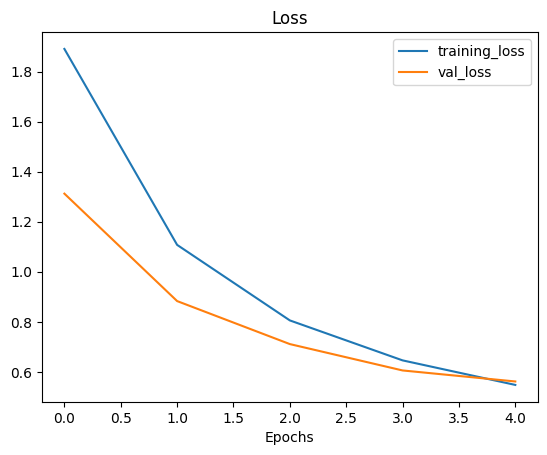

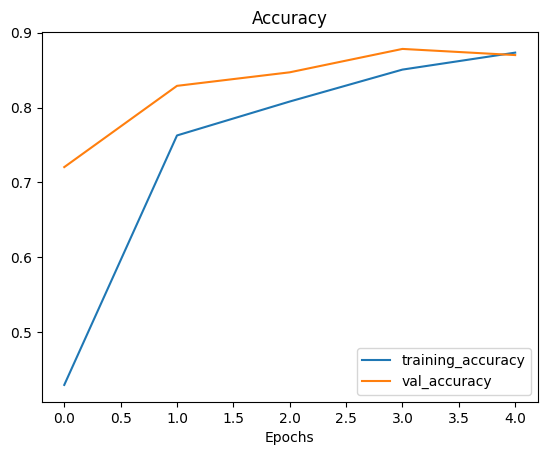

In [ ]:
# Noe lets plot the loss curves:

plot_loss_curves(history_0)

Plot proves that there is no overfitting and perhaps training it ofr more epochs will increase the accuracy.

## Getting the feature vector from a trained model:

lets demonstrate the Global Average Pooling 2D layer..

We have a tensor after our model goes through base_model of shape (None,7,7,1280)

But then after passing through GlobalAveragePooling2D, it turns into (None,1280)

Lets use a similiar shapes tensor of (1,4,4,3) and then pass it through pooling layer.

In [ ]:
# Define the inout shape:

input_shape = (1,4,4,3)

# Create a random tensor:
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"random input tensor is : {input_tensor}")

# Pass the random tensor through a global average pooling 2D:

global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f'Average Pooled tensor: {global_average_pooled_tensor}')

print(f"shape of the input tensor : {input_tensor.shape}")
print(f"shape of the average pooled tensor: {global_average_pooled_tensor.shape}")

random input tensor is : [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]
Average Pooled tensor: [[-0.09368646 -0.45840448 -0.2885598 ]]
shape of the input tensor : (1, 4, 4, 3)
shape of the average pooled tensor: (1, 3)


## Running a series of transfer learning experiments:

1. 'model_1' - use feature extraction transfer learning with 1% of the training data with data augmentation.

2. 'model_2' - use feature extraction transfer learning with 10% of the training with data augmentation.

3. 'model_3'- Use fine-tunning transfer learning on 10% of the training data with data augmentation.

4. 'model_4': use fine -tunning transfer learning on 100% of trainng data with data augmentation.

In [ ]:
# Download and unzip data:

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data('10_food_classes_1_percent.zip')

--2023-05-24 07:27:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.128, 142.250.107.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  54.1MB/s    in 2.4s    

2023-05-24 07:27:38 (54.1 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# Lets create train and test dir:

train_dir_1 = '10_food_classes_1_percent/train'
test_dir = '10_food_classes_1_percent/test'

In [ ]:
# lets walk through our data:

walk_through_dir('10_food_classes_1_percent')

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'

We have only 7 examples or training images in each class

## Getting and data preprcessing data from model_1:

In [ ]:
# set up data loaders:

IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_data_1 = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1,
                                                                   label_mode = 'categorical',
                                                                   image_size = IMG_SIZE,
                                                                   batch_size = BATCH_SIZE
                                                                   )
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = 'categorical',
                                                                batch_size = BATCH_SIZE,
                                                                image_size = IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding Data Augmentation right into the model:

To add data augmentation right into our models, we can us ethe layers inside:

 * tf.keras.layers.experimental.preprocessing ()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmenation stage with horizonal flipping, rotation, zoom , etc:

data_agmentation = keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
], name = 'data_augmentation')

### Visualize data augmentation layer:

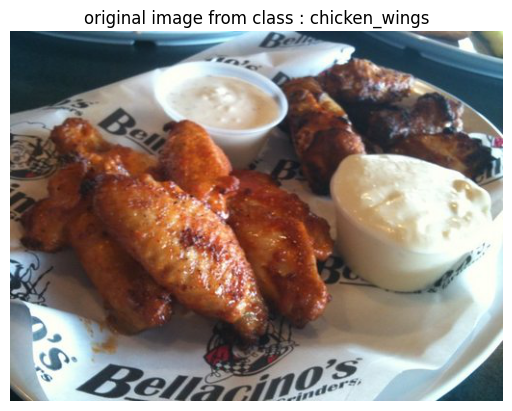

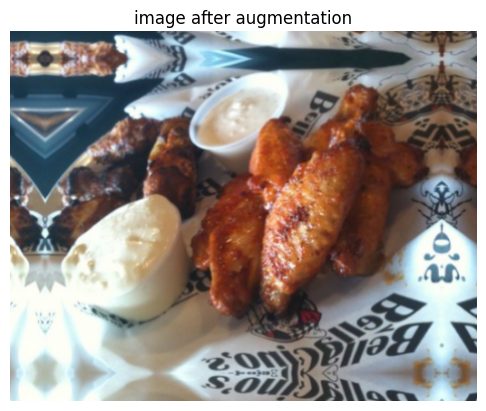

In [ ]:
# View a random image and compare it to its original image.
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1.class_names)

target_dir = '10_food_classes_1_percent/train/' + target_class

random_image = random.choice(os.listdir(target_dir))
random_img_path = target_dir+'/'+random_image

# read the random image
img = mpimg.imread(random_img_path)
plt.imshow(img)
plt.title(f'original image from class : {target_class}')
plt.axis(False);

# Now lets plot augmented random image:
augmented_img = data_agmentation(tf.expand_dims(img, axis = 0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"image after augmentation")
plt.axis(False);

## Lets build the model using 1% of the data with augmentation:

In [ ]:
from tensorflow.python import training
# Setup the input shape and base model and freeze the base model layers

input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# create input layer:
inputs = layers.Input(shape = input_shape, name = 'input_shape')

# Add in data augmentation sequential model as a layer
x = data_agmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it:
x = base_model(x, training = False)

# Pool output features of the base model:
x = layers.GlobalAveragePooling2D(name = 'Golbal_Average_Pooling_layer')(x)

# Put the output layer:
outputs = tf.keras.layers.Dense(10, activation = 'softmax', name = 'output_layer')(x)

# building the modle:
model_1 = keras.Model(inputs, outputs)

# Compile the modle:

model_1.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

# Fit the model:
history_1 = model_1.fit(train_data_1,
                        epochs= 5,
                        steps_per_epoch = len(train_data_1),
                        validation_data = test_data,
                        validation_steps = int(0.25*len(test_data)),
                        callbacks = [create_tensorboard_callback(dir_name ='transfer_learning',
                                                                experiment_name = '1_percent_data_augmentation')]
                        )

Saving TensorBoard log files to: transfer_learning/1_percent_data_augmentation/20230524-084002
Epoch 1/5
3/3 [==============================] - 22s 3s/step - loss: 2.3511 - accuracy: 0.0857 - val_loss: 2.2382 - val_accuracy: 0.1595
Epoch 2/5
3/3 [==============================] - 4s 1s/step - loss: 2.1795 - accuracy: 0.1571 - val_loss: 2.1107 - val_accuracy: 0.2352
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.9902 - accuracy: 0.3429 - val_loss: 1.9790 - val_accuracy: 0.3191
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.7411 - accuracy: 0.5857 - val_loss: 1.8812 - val_accuracy: 0.3668
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.5805 - accuracy: 0.6714 - val_loss: 1.8053 - val_accuracy: 0.3997


In [ ]:
# Check out the model summary:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_shape (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 Golbal_Average_Pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
# Evaluate on full test dataset:

model_1.evaluate(test_data)

79/79 [==============================] - 8s 87ms/step - loss: 1.8008 - accuracy: 0.4304


[1.8008224964141846, 0.430400013923645]

WIth only 1% training data and with data augmentation we are able to get around 40% of accuracy witch is not bad

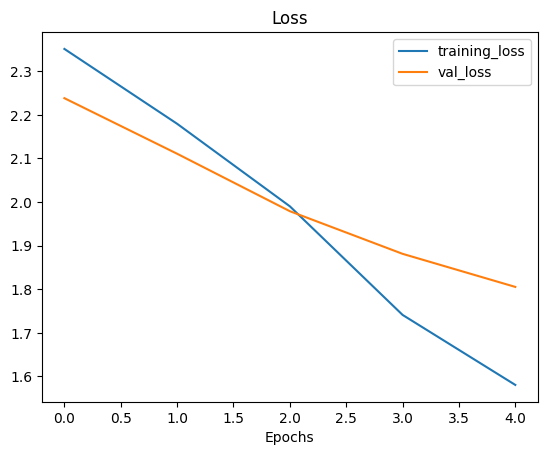

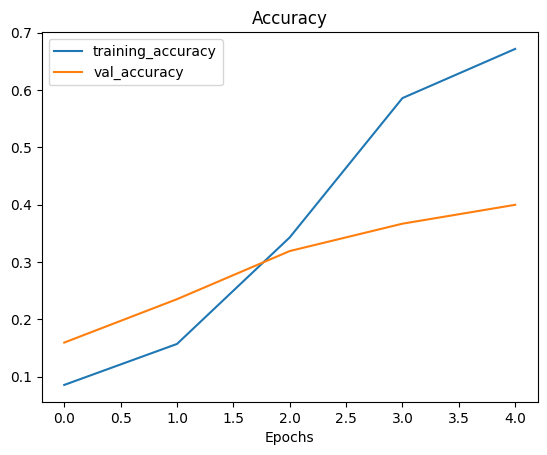

In [ ]:
# let plot the loss curve:
plot_loss_curves(history_1)

## Model 2: Feature extraction transfer learning with 10% data with data augmentation:

In [11]:
# Lets set up train and test directories:

train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

In [12]:
# Set data inputs:
import tensorflow as tf

IMG_SIZE = (224,224)

train_data_10 = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                    label_mode = 'categorical',
                                                                    image_size = IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = 'categorical',
                                                                image_size = IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [40]:
# Create model 2 with data augmentation:

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# build data augmentation layer:
data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2)
], name = 'data_augmentation')

# setup input shape to the model:
input_shape = (224,224,3)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create the inputs and outputs ():
inputs = layers.Input(shape = input_shape, name = 'input_layer')
x = data_augmentation(inputs)
x = base_model(x, training = False)
x= layers.GlobalAveragePooling2D(name = 'global_average_pooling_layer')(x)

outputs = layers.Dense(10, activation = 'softmax', name = 'output_layer')(x)

# Build the model:
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model:
model_2.compile(
    loss= 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [14]:
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainabl

### Creating modelcheckpoint() callback:

In [15]:
# Set model check point path:

checkpoint_path = '10_%_model_checkpoints_weights/checkpoint.ckpt'

#Cretaing a ModelCheckpint callback only to save the weight per epoch:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         save_weights_only= True,
                                                         save_best_only = False,
                                                         save_freq = 'epoch',
                                                         verbose = 1)

In [16]:
# Fit the data to the model:
intial_epochs = 5
history_2 = model_2.fit(train_data_10,
                        epochs = intial_epochs,
                        steps_per_epoch = len(train_data_10),
                        validation_data = test_data,
                        validation_steps = int(0.25*len(test_data)),
                        callbacks = [create_tensorboard_callback(dir_name = 'transfer_learning',
                                                                 experiment_name = '10_percent_dat_augmentation'),
                                     checkpoint_callback]
                        )
                        

Saving TensorBoard log files to: transfer_learning/10_percent_dat_augmentation/20230525-113756
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9523 - accuracy: 0.3613
Epoch 1: saving model to 10_%_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 31s 695ms/step - loss: 1.9523 - accuracy: 0.3613 - val_loss: 1.4218 - val_accuracy: 0.6793
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3179 - accuracy: 0.6720
Epoch 2: saving model to 10_%_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 12s 501ms/step - loss: 1.3179 - accuracy: 0.6720 - val_loss: 0.9932 - val_accuracy: 0.7714
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9883 - accuracy: 0.7933
Epoch 3: saving model to 10_%_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 14s 560ms/step - loss: 0.9883 - accuracy: 0.7933 - val_loss: 0.7705 - val_accuracy: 0.8273
Epoch 4/5
24/2

In [17]:
evaluation_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 71ms/step - loss: 0.6361 - accuracy: 0.8328


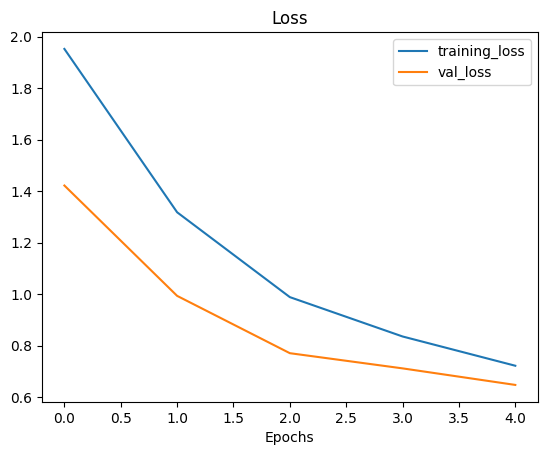

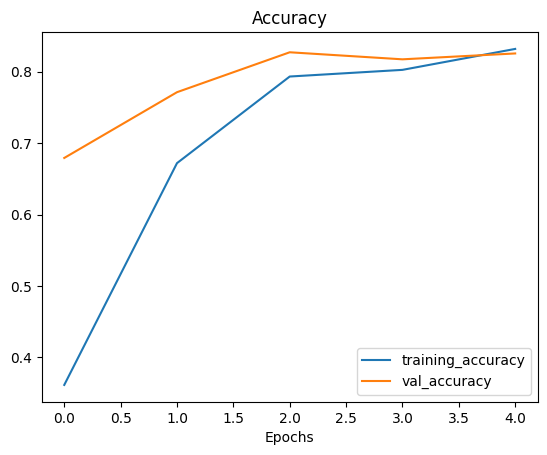

In [18]:
# Plot model loss curves:

plot_loss_curves(history_2)

### Loading in checkpointed weights:

loading in checkpoints weights returns a models a specific checkpoint

In [41]:
# Evaluate model_2 with loaded weights:

loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 9s 67ms/step - loss: 2.5357 - accuracy: 0.0672


In [42]:
evaluation_results

[0.6360530853271484, 0.8327999711036682]

In [ ]:
evaluation_results == loaded_weights_model_results

False

In [ ]:
# check to see if loaded model results are very close to original model results:

import numpy as np

np.isclose(np.array(evaluation_results), np.array(loaded_weights_model_results))

array([ True,  True])

In [ ]:
# check the results between two models results:

print(np.array(loaded_weights_model_results)- np.array(evaluation_results))

[-5.96046448e-08  0.00000000e+00]


The difference is very small this is because of how the numbers are stored there is always some differnce when numbers decimal points are very some.

## Model 3: Fine-tunning an existing model on 10% of the data:

In [22]:
# Layers in our loaded model:
model_2.layers

In [23]:
# Are these layers trainable?

for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fe4599c9990> True
<keras.engine.sequential.Sequential object at 0x7fe459ac21a0> True
<keras.engine.functional.Functional object at 0x7fe4403d70a0> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7fe440317cd0> True
<keras.layers.core.dense.Dense object at 0x7fe458961060> True


In [24]:
# lets check layers in base_model that is EfficientNetB0:

for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

currently all are not trainable since we have kept trainable to False.

In [25]:
# How many trainabel varibales are in our base_model:

print(len(model_2.layers[2].trainable_variables))

0


In [47]:
# To beign fine tunning lets start by setting last 10 layers of our base_model to trainable to True:

base_model.trainable = True

# freeze all layers exacept the last 10 layers:
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile our model since we have changed the base_model:
model_2.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), # lowering th eLR
    metrics = ['accuracy']
)

In [48]:
# check which layers are tunable
for i,layer in enumerate(model_2.layers[2].layers):
  print(i,layer.name, layer.trainable)

0 input_2 False
1 rescaling_2 False
2 normalization_1 False
3 rescaling_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [28]:
print(len(model_2.trainable_variables))

12


In [29]:
# fine tune fro another 5 epochs:
fine_tune_epochs = intial_epochs + 5

history_fine_tune = model_2.fit(train_data_10,
                                epochs = fine_tune_epochs,
                                validation_data = test_data,
                                validation_steps = int(0.25*len(test_data)),
                                initial_epoch = history_2.epoch[-1],# start training from last epoch from previous model
                                callbacks = [create_tensorboard_callback(dir_name = 'transfer_leraning',
                                                                         experiment_name = '10_percent_fine_tune_last_10')])

Saving TensorBoard log files to: transfer_leraning/10_percent_fine_tune_last_10/20230525-114317
Epoch 5/10
24/24 [==============================] - 23s 539ms/step - loss: 0.6389 - accuracy: 0.8280 - val_loss: 0.4747 - val_accuracy: 0.8569
Epoch 6/10
24/24 [==============================] - 11s 452ms/step - loss: 0.4926 - accuracy: 0.8507 - val_loss: 0.4861 - val_accuracy: 0.8536
Epoch 7/10
24/24 [==============================] - 9s 353ms/step - loss: 0.4331 - accuracy: 0.8653 - val_loss: 0.5007 - val_accuracy: 0.8454
Epoch 8/10
24/24 [==============================] - 9s 338ms/step - loss: 0.3907 - accuracy: 0.8853 - val_loss: 0.4938 - val_accuracy: 0.8438
Epoch 9/10
24/24 [==============================] - 9s 346ms/step - loss: 0.3500 - accuracy: 0.8960 - val_loss: 0.4812 - val_accuracy: 0.8470
Epoch 10/10
24/24 [==============================] - 10s 401ms/step - loss: 0.3238 - accuracy: 0.9027 - val_loss: 0.4427 - val_accuracy: 0.8618


In [30]:
results_fine_tune = model_2.evaluate(test_data)

79/79 [==============================] - 6s 76ms/step - loss: 0.4440 - accuracy: 0.8560


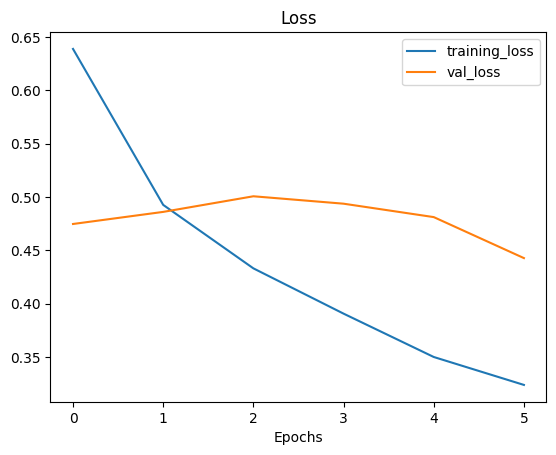

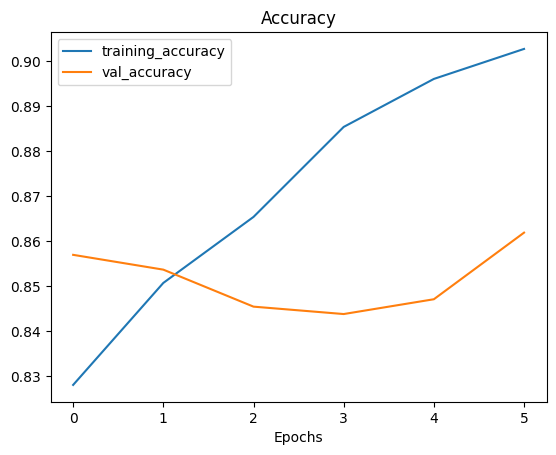

In [31]:
# Plotting the loss curves:
plot_loss_curves(history_fine_tune)

In [32]:
import matplotlib.pyplot as plt

In [33]:
# Lest crearte the function to compare the historys:

def compare_historys(original_history, new_history, intial_epochs = 5):
  """
  Compares two Tensorflow history objects
  """

  # get the orginal history data:
  acc = original_history.history['accuracy']
  loss = original_history.history['loss']

  val_acc = original_history.history['val_accuracy']
  val_loss = original_history.history['val_loss']


  # Get the new history data:
  total_acc = acc + new_history.history['accuracy']
  total_loss = loss + new_history.history['loss']

  total_val_acc = val_acc + new_history.history['val_accuracy']
  total_val_loss = val_loss + new_history.history['val_loss']

  # Plot the total accuracy for training and validation:
  plt.figure(figsize = (8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label = 'training_accuracy')
  plt.plot(total_val_acc, label = 'validation_accuracy')
  plt.plot([intial_epochs-1, intial_epochs-1], plt.ylim(), label ='start fine tunning')
  plt.legend(loc = 'lower right')
  plt.title('training and validation accuracy')

  # Plot the total los for training and validation:
  plt.figure(figsize = (8,8))
  plt.subplot(2,1,2)
  plt.plot(total_loss, label = 'training_loss')
  plt.plot(total_val_loss, label = 'validation_loss')
  plt.plot([intial_epochs-1, intial_epochs-1], plt.ylim(), label ='start fine tunning')
  plt.legend(loc = 'upper right')
  plt.title('training and validation loss')

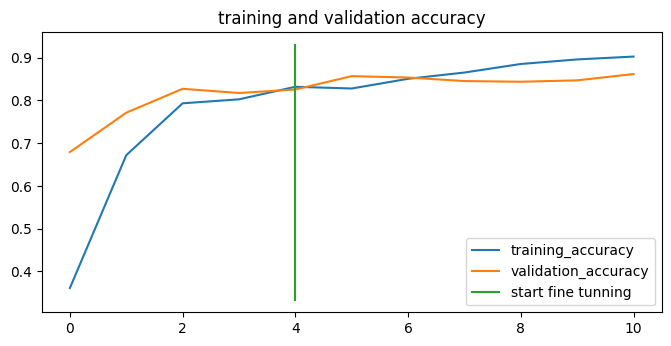

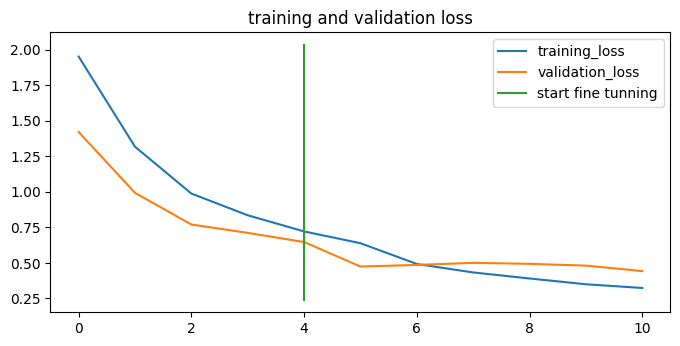

In [34]:
compare_historys(history_2,
                 history_fine_tune,
                 intial_epochs = 5)

## Model4 : Fine tunning an existing model on all of the data:

Download and unzip 10 classes of Food101 data with all images.

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data('10_food_classes_all_data.zip')

--2023-05-25 11:26:59--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.128, 173.194.202.128, 173.194.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  77.3MB/s    in 4.1s    

2023-05-25 11:27:03 (120 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [51]:
# Sert up training and testing dir:

train_dir = '10_food_classes_all_data/train'
test_dir = '10_food_classes_all_data/test'

In [52]:
# How many image are we working with now:
walk_through_dir('10_food_classes_all_data')

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.

In [53]:
# Set up data inputs:

import tensorflow as tf

IMG_SIZE = (224,224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode = 'categorical',
                                                                 image_size = IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = 'categorical',
                                                                image_size = IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


To train a fine-tunning model (model_4) we need to revert model_2 back to its feature extraction weights.

In [43]:
# Load weights from checkpoints, that way we can fine-tune from
# the same stage as the 10 % data model was fine-tunned from

model_2.load_weights(checkpoint_path)

In [44]:
model_2.evaluate(test_data)

79/79 [==============================] - 7s 79ms/step - loss: 0.6361 - accuracy: 0.8328


[0.6360531449317932, 0.8327999711036682]

In [45]:
evaluation_results

[0.6360530853271484, 0.8327999711036682]

Now our model is back to stage where we haven't fine tunned the base model

In [49]:
# Lets drill into our base_model and see if layers are trainable:

for layer_num, layer in enumerate(model_2.layers[2].layers):
  print(layer_num,layer.name,layer.trainable)

0 input_2 False
1 rescaling_2 False
2 normalization_1 False
3 rescaling_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [50]:
model_2.evaluate(test_data)

79/79 [==============================] - 9s 72ms/step - loss: 0.6361 - accuracy: 0.8328


[0.6360530257225037, 0.8327999711036682]

In [58]:
# Lets compile:

model_2.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [59]:
# continue to train and fin etune the model to our data (100 % training data):

fine_tune_epochs = intial_epochs + 5

history_fine_tune_full = model_2.fit(train_data,
                                     epochs= fine_tune_epochs,
                                     validation_data = test_data,
                                     validation_steps = int(0.25*len(test_data)),
                                     initial_epoch = history_2.epoch[-1],
                                     callbacks = [create_tensorboard_callback(dir_name = 'transfer_learning',
                                                                              experiment_name = 'full_data_fine_tunned')])

Saving TensorBoard log files to: transfer_learning/full_data_fine_tunned/20230525-122051
Epoch 5/10
235/235 [==============================] - 62s 227ms/step - loss: 0.5406 - accuracy: 0.8340 - val_loss: 0.1354 - val_accuracy: 0.9605
Epoch 6/10
235/235 [==============================] - 47s 197ms/step - loss: 0.4018 - accuracy: 0.8709 - val_loss: 0.1517 - val_accuracy: 0.9474
Epoch 7/10
235/235 [==============================] - 46s 191ms/step - loss: 0.3201 - accuracy: 0.8935 - val_loss: 0.1247 - val_accuracy: 0.9655
Epoch 8/10
235/235 [==============================] - 44s 184ms/step - loss: 0.2668 - accuracy: 0.9092 - val_loss: 0.1641 - val_accuracy: 0.9474
Epoch 9/10
235/235 [==============================] - 42s 178ms/step - loss: 0.2248 - accuracy: 0.9292 - val_loss: 0.1571 - val_accuracy: 0.9441
Epoch 10/10
235/235 [==============================] - 38s 160ms/step - loss: 0.1908 - accuracy: 0.9349 - val_loss: 0.1824 - val_accuracy: 0.9408


In [60]:
# Lest evaluate it on full test data:
results_fine_tuned_full = model_2.evaluate(test_data)

79/79 [==============================] - 7s 72ms/step - loss: 0.1892 - accuracy: 0.9368


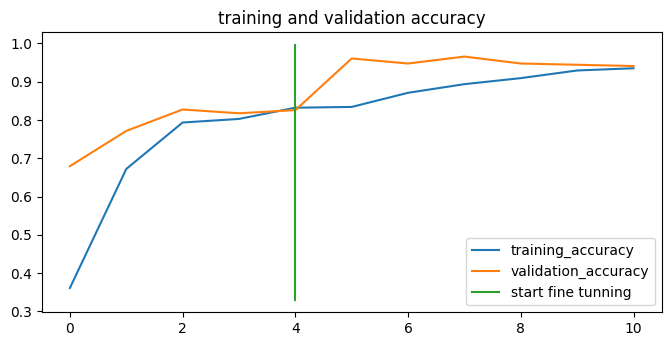

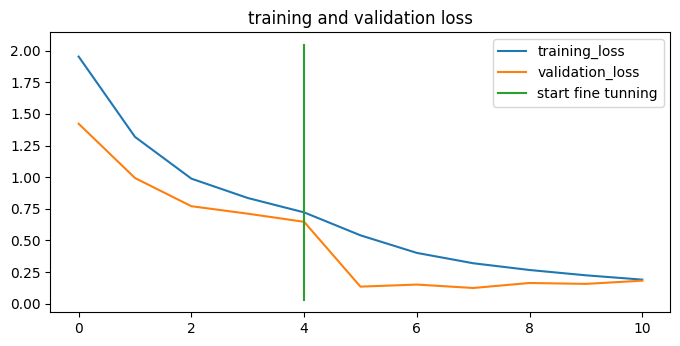

In [62]:
# Lets compare the histories by plotting the curves:

compare_historys(original_history = history_2,
                 new_history = history_fine_tune_full,
                 intial_epochs = 5)

Now those are wonderfull curves, this model is not overfitting and also achiveing accuracy around 94%.


## Viewing our experiment data on tensorboard:

In [64]:
!tensorboard dev upload --logdir ./transfer_learning\
  --name 'Transfer Learning experiments with 10 Food101 Classes'\
  --description 'A series of differnet transfer learning experiments with varying amount of data'\
  --one_shot 

2023-05-25 12:44:49.965303: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   TKTV-FJKK



New experiment created. View your TensorBoard at: https://tensorboard.dev/ex

 Our Experiment results are stored here in this link :
 
https://tensorboard.dev/experiment/4R54DlmcRZ6LyJJUkHebhQ/


In [65]:
!tensorboard dev list

2023-05-25 12:55:47.696114: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/4R54DlmcRZ6LyJJUkHebhQ/
	Name                 Transfer Learning experiments with 10 Food101 Classes
	Description          A series of differnet transfer learning experiments with varying amount of data
	Id                   4R54DlmcRZ6LyJJUkHebhQ
	Created              2023-05-25 12:45:31 (10 minutes ago)
	Updated              2023-05-25 12:45:35 (10 minutes ago)
	Runs                 8
	Tags                 5
	Scalars              132
	Tensor bytes         0
	Binary object bytes  3751615
https://tensorboard.dev/experiment/Ki1uNYNjR9Kt3DTVENirLg/
	Name                 EfficientNetB0 vs ResNet50V2
	Description          Comparing two different Tfhub feature Extraction model using only 10% of data
	Id                   Ki1uNYNjR9Kt3DTVENirLg
	Created              2023-05-22 17:22:13
	Updated              2023-05-22 17:22:17
	Runs    